# EYE BLINK DETECTION:
# 2) Adaptive Model
For this part, we will experiment on the variables

> EAR_THRESHOLD = 0.21 # eye aspect ratio to indicate blink  
> EAR_CONSEC_FRAMES = 3 # number of consecutive frames the eye must be below the threshold  
> SKIP_FIRST_FRAMES = 0 # how many frames we should skip at the beggining  

to make them adaptive to subject of the video. We will basically ***normalize*** across samples of a subject.

**NOT:** Starting from this section, we will use utils.py script to import necessary function that we implement on previous notebooks.

In [1]:
# install pycausalimpact
!pip install pycausalimpact

# import packages
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import scipy.stats as st
from IPython.display import YouTubeVideo
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from causalimpact import CausalImpact
from matplotlib import gridspec
%matplotlib inline

# import utility functions
from utils import *

# define three constants. 
# You can later experiment with these constants by changing them to adaptive variables.
EAR_THRESHOLD = 0.21 # eye aspect ratio to indicate blink
EAR_CONSEC_FRAMES = 3 # number of consecutive frames the eye must be below the threshold
SKIP_FIRST_FRAMES = 0 # how many frames we should skip at the beggining

**Load outputs of basic model:**

In [2]:
#define path and dataset_name
path = "../input/eye-blink-detection-1-simple-model"
dataset_name = "talking"

# load datasets
c_pred, b_pred, df, c_test, b_test, s_str = load_datasets(path, dataset_name)

# check results
print(np.array(c_pred).shape, np.array(b_pred).shape)
print(np.array(c_test).shape, np.array(b_test).shape)
print()

#display statistics
print(s_str)

#display the first rows of data frame
df[:3]

(5000,) (45, 2)
(5000,) (61, 2)

Processing talking.avi has done.

Video info
FPS: 30.0
FRAME_COUNT: 5000
DURATION (s): 166.67

Statistics on the prediction set are
TOTAL NUMBER OF FRAMES PROCESSED: 5000
NUMBER OF CLOSED FRAMES: 323
NUMBER OF BLINKS: 45

Statistics on the test set are
TOTAL NUMBER OF FRAMES PROCESSED: 5000
NUMBER OF CLOSED FRAMES: 153
NUMBER OF BLINKS: 61

EYE CLOSENESS FRAME BY FRAME TEST SCORES

ACCURACY: 0.9640

AUC: 0.9656

CONFUSION MATRIX:
[[4672  175]
 [   5  148]]

FALSE POSITIVES:
5 out of 153 positive labels (0.0327%)

FALSE NEGATIVES:
175 out of 4847 negative labels (0.0361%)

PRECISION, RECALL, F1 scores:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4847
           1       0.46      0.97      0.62       153

    accuracy                           0.96      5000
   macro avg       0.73      0.97      0.80      5000
weighted avg       0.98      0.96      0.97      5000



,frame_no,face_detected,face_coordinates,left_eye_coordinates,right_eye_coordinates,left_ear,right_ear,avg_ear,closeness,blink_no,blink_start_frame,blink_end_frame,reserved_for_calibration
0,1,True,"[[174, 114], [353, 114], [174, 293], [353, 293]]","[[276, 167], [286, 158]]","[[202, 179], [210, 170]]",0.304218,0.320053,0.312135,0,0,0,0,False
1,2,True,"[[174, 114], [353, 114], [174, 293], [353, 293]]","[[277, 167], [286, 158]]","[[203, 180], [211, 170]]",0.306832,0.334046,0.320439,0,0,0,0,False
2,3,True,"[[174, 114], [353, 114], [174, 293], [353, 293]]","[[277, 167], [287, 158]]","[[204, 181], [212, 171]]",0.297228,0.313230,0.305229,0,0,0,0,False


# Analyzing Data

After seeing the results of basic model, now we can start **implementing adaptive thresholds model**.

Let's take a glance at our data by plotting it.

SLOPE = -0.00000


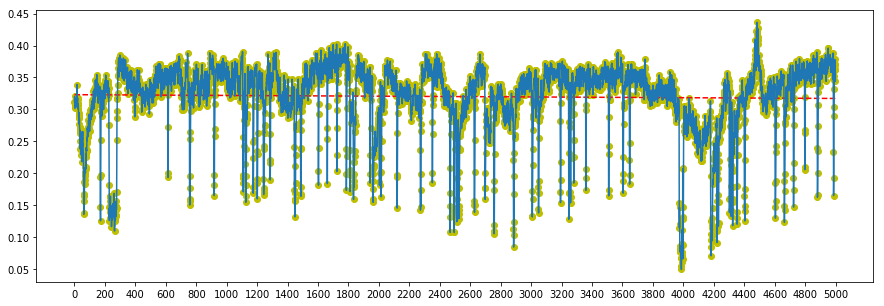

In [3]:
# plot whole data 
data = np.array(df['avg_ear'])
plt.figure(figsize=(15,5))
plt.xticks(np.arange(0, len(data)+1, 200))
m,b = np.polyfit(np.arange(len(data)),data, 1)
print("SLOPE = {:.5f}".format(m))
plt.plot(np.arange(len(data)),data,'yo', np.arange(len(data)), m*np.arange(len(data))+b, '--r')
plt.plot(data);

Remark that slope of linear regression is ideally m >= 0. Because blinking occurs rarely and they don't impact much to the general trend of ear values. 

If we get first 100 ear values and plot them with **linear fitting** what it would be like?

SLOPE = -0.00085


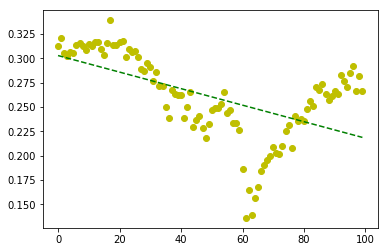

In [4]:
#get first n frames and plot it with linear regression
n = 100
data100 = data[:n]
m,b = np.polyfit(np.arange(n),data100, 1)
print("SLOPE = {:.5f}".format(m))
plt.plot(np.arange(n),data100,'yo', np.arange(n), m*np.arange(n)+b, '--g');

So getting first n = 100 frames doesn't catch a full blink behaviour, ending parts are missing. To get a proper blink, we need to estimate a minimum frame count truly. 

Remark that, the linear regression above has negative slope. So we need to iterate on number of n (starting with some minimum treshold like 50) until we get a positive slope just like the behaviour of full dataset above. Also if slope is converges around some proper value it will be a good sign for proper n. This way we will be sure on that we caught a full blink.

# Adaptive Thresholds: SKIP_FIRST_FRAMES

So we define a function to estimate calibration hyperparameter n.

In [5]:
# estimate SKIP_FIRST_FRAMES threshold
# returns n -> estimated value of the threshold
# m0 -> slope at this point
# array of slopes until this point
def estimate_first_n(data, start_n=50, limit_n=300, step=1, epsilon=10e-8):
    n = start_n 
    M=[]
    while True:
        # for first n values fit a linear regression line 
        data0 = data[:n]
        m0,b0 = np.polyfit(np.arange(n),data0, 1)
        M.append(m0)
        
        # check if n + step reaches limit
        if n + step > limit_n-1:
            print("error - reached the limit")
            break

        # for first n + step values fit a linear regression line 
        data1 = data[:n+step]
        m1,b1 = np.polyfit(np.arange(n + step),data1, 1)

        # if m1-m0 converges to epsilon
        if abs(m1 - m0) < epsilon and m0 > 0:
            break
        n += step
        
    return n, m0, M

In [6]:
# utility function to get fps of the video and to calculate frame count from given duration
def secs_to_frame_count(input_full_path, seconds):
    # read fps of the video
    fps = cv2.VideoCapture(input_full_path).get(cv2.CAP_PROP_FPS)
    # calculate 
    frame_count = seconds * fps
    return frame_count

n = 222.00000
m = 0.00032


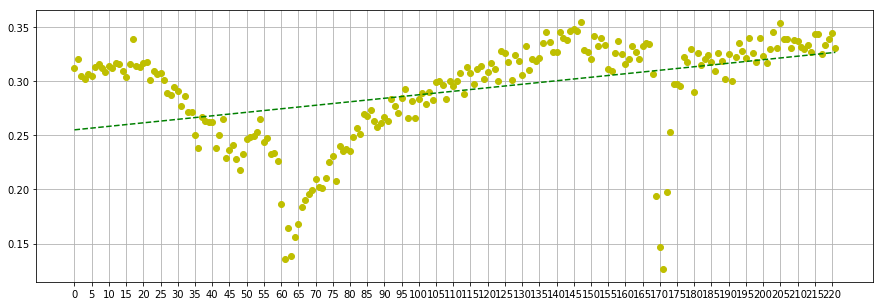

In [7]:
# calculate a limit_n for 10 secs with using fps of the video
limit_secs = 10
limit_frame = secs_to_frame_count("../input/blinkdata/talkingFace/talking.avi", limit_secs)

# run the function above
n, m0, M = estimate_first_n(data, limit_n=limit_frame)

# get first n frames and plot it with linear regression
calibration = data[:n]
m,b = np.polyfit(np.arange(n), calibration, 1)
linear = m*np.arange(n)+b
print("n = {:.5f}".format(n))
print("m = {:.5f}".format(m))
plt.figure(figsize=(15,5))
plt.xticks(np.arange(0, n, 5))
plt.grid()
plt.plot(np.arange(n),calibration,'yo', np.arange(n), linear, '--g');

We can see that our function can detect some full blinks. Actually this function waits a blink to finish it's action, but doesn't guarantee to detect at least one blink. There is a possibility that if driver doesn't blink for a long time and his ears just decrease without any blink in initial period, algorithm doesn't return an error.

Also there could be another problem, calibration phase may exceed limit_n = 10 secs for most cases. So we need to find an adaptive way to use limit_n and run the function until it gets **at least one blink**.

**NOTE TO MYSELF:** research casual impact for this case https://github.com/dafiti/causalimpact

# Another Problem: Facial Actions (Smiling, Yawning etc.)

Let's go back to the data analysis. As you remember, we have detected 2 blinks.

First, the blink which we detected between 30th and 90th frames. With enlarged tails it can be anywhere between 0-163. Second, the blink between 138-218.

Plot both of them to analyze seperately.

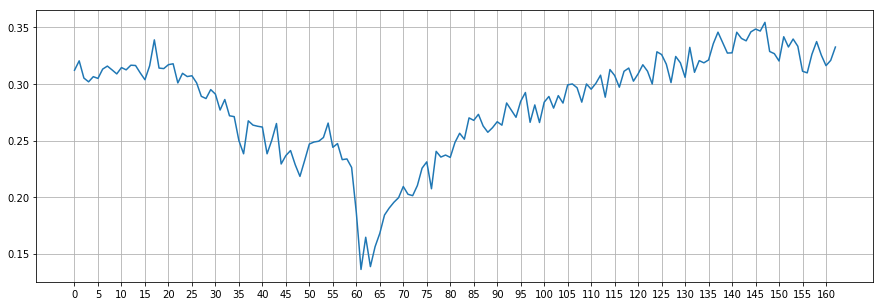

In [8]:
# plot data between 0 - 163
blink1 = calibration[:163]
plt.figure(figsize=(15,5))
plt.xticks(np.arange(0, len(blink1), 5))
plt.grid()
plt.plot(blink1);

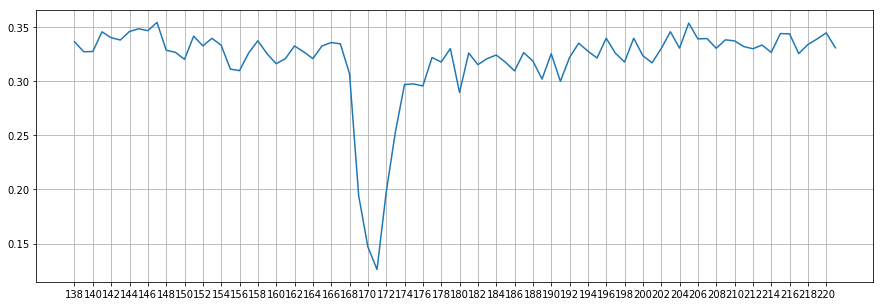

In [9]:
# plot data between 138 - 218
blink2 = calibration[138:]
plt.figure(figsize=(15,5))
plt.xticks(np.arange(0, len(blink2), 2),np.arange(138, 138+len(blink2),2))
plt.grid()
plt.plot(blink2);

If we examine two blinks with more precise ranges and get frame samples by running simple_model, we can display them to check their nature.
* blink1 -> (56,87)
* blink2 -> (165,178)

In [10]:
# run simple model to get frames list
_, _, _, fr, _, _ = simple_model("../input/blinkdata/talkingFace/talking.avi");

Processing talking.avi has done.


Video info
FPS: 30.0
FRAME_COUNT: 5000
DURATION (s): 166.67

Statistics on the prediction set are
TOTAL NUMBER OF FRAMES PROCESSED: 5000
NUMBER OF CLOSED FRAMES: 323
NUMBER OF BLINKS: 45




1th blink started at: 56th frame, middle of action at: 72th frame, ended at: 87th frame


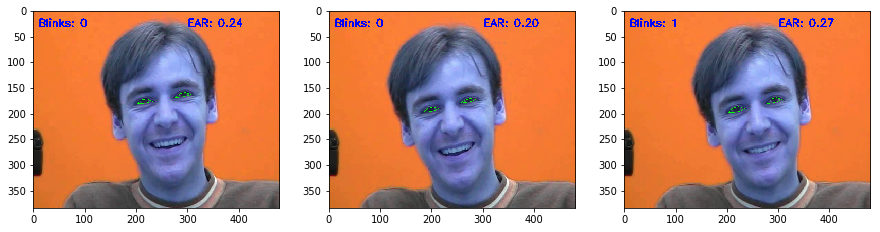

2th blink started at: 165th frame, middle of action at: 172th frame, ended at: 178th frame


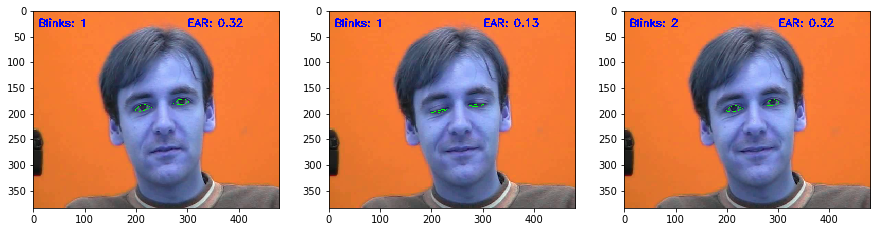

In [11]:
# display starting, middle and ending frames of two blinks
display_blinks([(56,87),(165,178)], fr)

It turns out that blink1 is a smiling face and arguably not a proper blink. On the other hand blink2 is a normal blink. We will use this information for later experiments when we need a normal blink.

We can double check this by looking at blink prediction and blink test data from of simple model.

In [12]:
# print first 5 blinks of test data
print(b_test[0:5])

# print first 5 blinks of prediction data
print(b_pred[0:5])

[array([168, 176]), array([225, 232]), array([274, 280]), array([613, 617]), array([756, 763])]
[array([61, 73]), array([170, 173]), array([228, 278]), array([757, 761]), array([918, 920])]


We can see that simpe model predicts blink1(56,87) as a blink when annotations don't. So it's a false-positive sample. Moreover blink2(165,178) is catched by both.

Consequently facial expressions like smiling and ywaning are drawbacks of both simple and adaptive models. Btw machine learning approaches can be good solution here but we need a practical solution which can be added to these two models for now. We will implement SVM and deep learning models in later notebooks.

**NOTE TO MYSELF:** Research ARIMA and correlation analysis for this case.

# Adaptive Thresholds: EAR_THRESHOLD
While continuing to build adaptive model, we can try something with error plots:

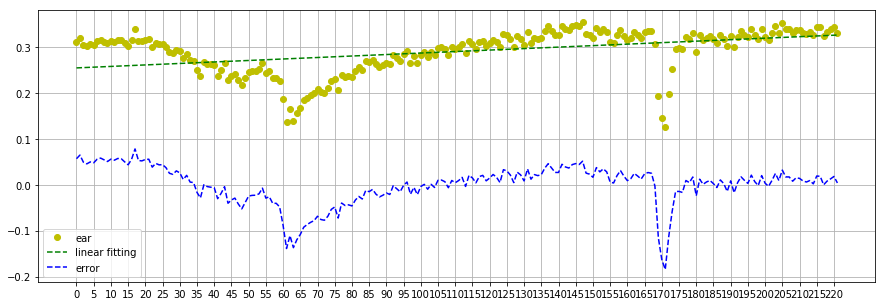

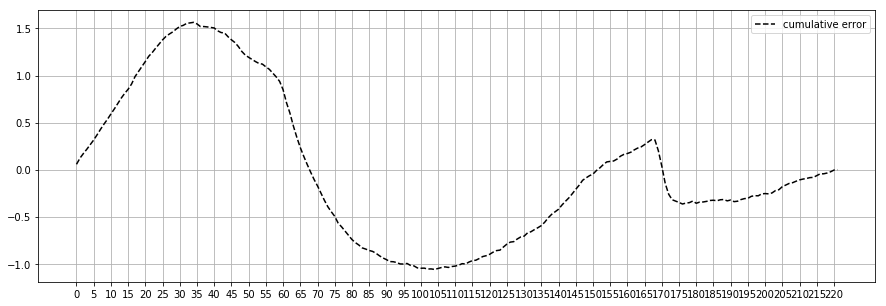

In [13]:
# calculate errors
errors = calibration - linear

# plot errors
plt.figure(figsize=(15,5))
plt.xticks(np.arange(0, n, 5))
plt.grid()
plt.plot(calibration,'yo', linear, '--g', errors, '--b')
plt.legend(labels = ['ear', 'linear fitting', 'error'])
plt.show()

# cumulative errors
cum_errors = errors.cumsum()

# plot cumulative errors
plt.figure(figsize=(15,5))
plt.xticks(np.arange(0, n, 5))
plt.grid()
plt.plot(np.arange(n), cum_errors, '--k')
plt.legend(labels = ['cumulative error'])
plt.show();

Cumulative error doesn't say much on blinks since it's effect delayed. But normal error can be used for anomalie detection.

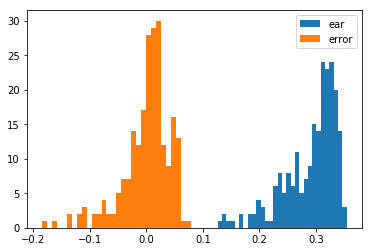

In [14]:
# plot histogram of calibration and errors
plt.hist(calibration, bins=30)
plt.hist(errors, bins=30)
plt.legend(['ear', 'error']);

Also errors more like normally distributes than ear values so can use some statistical tools on it.  

**First we can try outlier detection with IRQ method. Let's define a function that removes outliers from a list:**

In [15]:
# remove outliers from a list by using IQR method
def detect_outliers_iqr(input_list, alpha=1.5):
    # calculate interquartile range
    q25, q75 = np.percentile(input_list, 25), np.percentile(input_list, 75)
    iqr = q75 - q25
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    
    # calculate the outlier cutoff
    cut_off = iqr * alpha
    lower, upper = q25 - cut_off, q75 + cut_off
    
    # identify outliers
    outliers = [(i, x) for (i, x) in list(enumerate(input_list, 1)) if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    
    # remove outliers
    clean_input_list = [x for x in input_list if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(clean_input_list))
    print("")
    
    return clean_input_list, outliers, upper, lower

In [16]:
# run detect_outliers_iqr() on errors
_, outliers, upper, lower =  detect_outliers_iqr(errors)
outlier_indexes = list(zip(*outliers))[0]
outlier_values = list(zip(*outliers))[1]

# run detect_outliers_iqr() on calibration
_, outliers_c, upper_c, lower_c =  detect_outliers_iqr(calibration)
outlier_indexes_c = list(zip(*outliers_c))[0]
outlier_values_c = list(zip(*outliers_c))[1]

Percentiles: 25th=-0.017, 75th=0.025, IQR=0.042
Identified outliers: 13
Non-outlier observations: 209

Percentiles: 25th=0.265, 75th=0.326, IQR=0.061
Identified outliers: 7
Non-outlier observations: 215



**Also we can try confidence interval method:**

In [17]:
# calculate upper and lower limits for given confidence interval
def detect_outliers_conf(input_list, confidence=0.95):
    # identify boudaries
    lower, upper  = st.t.interval(confidence, len(input_list)-1, loc=np.mean(input_list), \
                                        scale=st.sem(input_list))
    
    # identify outliers
    outliers = [(i, x) for (i, x) in list(enumerate(input_list, 1)) if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    
    # remove outliers
    clean_input_list = [x for x in input_list if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(clean_input_list))
    print("")
    
    return clean_input_list, outliers, upper, lower

In [18]:
# run detect_outliers_conf() for 0.99 on errors
_, _, _, lower_conf = detect_outliers_conf(errors, 0.99)

# run detect_outliers_conf() for 0.99 on calibration
_, _, _, lower_conf_c = detect_outliers_conf(calibration, 0.99)

Identified outliers: 180
Non-outlier observations: 42

Identified outliers: 201
Non-outlier observations: 21



Another outliner detection using z_scores.

In [19]:
# calculate upper and lower limits for given confidence interval
def detect_outliers_z(input_list, z_limit=2):
    # identify boudaries
    mu = input_list.mean()
    sigma = input_list.std()
    val = z_limit * sigma
    lower  =  mu - val
    upper =  mu + val
    
    # identify outliers
    outliers = [(i, x) for (i, x) in list(enumerate(input_list, 1)) if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    
    # remove outliers
    clean_input_list = [x for x in input_list if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(clean_input_list))
    print("")
    
    return clean_input_list, outliers, upper, lower

In [20]:
# run detect_outliers_z() for z_limit=2 on errors
_, outliers_z, _, lower_z = detect_outliers_z(errors, 2)
outlier_indexes_z = list(zip(*outliers_z))[0]
outlier_values_z = list(zip(*outliers_z))[1]

# run detect_outliers_z() for z_limit=2 on calibration
_, outliers_z_c, _, lower_z_c = detect_outliers_z(calibration, 2)
outlier_indexes_z_c = list(zip(*outliers_z_c))[0]
outlier_values_z_c = list(zip(*outliers_z_c))[1]

Identified outliers: 12
Non-outlier observations: 210

Identified outliers: 12
Non-outlier observations: 210



Put them all together and plot:

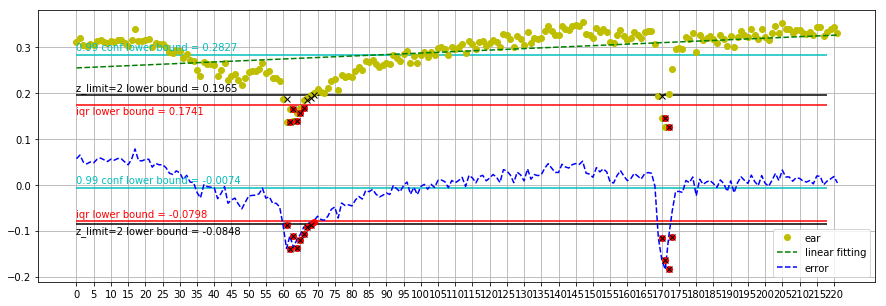

In [21]:
# plot calibration and errors
plt.figure(figsize=(15,5))
plt.xticks(np.arange(0, n, 5))
plt.grid()
plt.plot(calibration,'yo', linear, '--g', errors, '--b')
plt.legend(labels = ['ear', 'linear fitting', 'error'], loc='lower right')

# plot outliers for errors
plt.plot(outlier_indexes, outlier_values, 'ro')
plt.hlines(lower, 0, 218, colors='r', linestyles='-')
plt.text(0, lower + 0.01, 'iqr lower bound = {:.4f}'.format(lower), color='r')

# plot outliers for calibration
plt.plot(outlier_indexes_c, outlier_values_c, 'ro')
plt.hlines(lower_c, 0, 218, colors='r', linestyles='-')
plt.text(0, lower_c - 0.02, 'iqr lower bound = {:.4f}'.format(lower_c), color='r')

# 99% confidence for errors
plt.hlines(lower_conf, 0, 218, colors='c', linestyles='-')
plt.text(0, lower_conf + 0.01, '0.99 conf lower bound = {:.4f}'.format(lower_conf), color='c')

# 99% confidence for calibration
plt.hlines(lower_conf_c, 0, 218, colors='c', linestyles='-')
plt.text(0, lower_conf_c + 0.01, '0.99 conf lower bound = {:.4f}'.format(lower_conf_c), color='c')

# z_limit=2 for errors
plt.plot(outlier_indexes_z, outlier_values_z, 'kx')
plt.hlines(lower_z, 0, 218, colors='k', linestyles='-')
plt.text(0, lower_z - 0.02, 'z_limit=2 lower bound = {:.4f}'.format(lower_z), color='k')

# z_limit=2 for calibration
plt.plot(outlier_indexes_z_c, outlier_values_z_c, 'kx')
plt.hlines(lower_z_c, 0, 218, colors='k', linestyles='-')
plt.text(0, lower_z_c + 0.01, 'z_limit=2 lower bound = {:.4f}'.format(lower_z_c), color='k')
plt.show()

.99 confidence interval didin't produce significant results. 

And running **detect_outliers_iqr()** on errors gives much better results than running on calibration since it's lower bound is better for estimating blinks. 

* lower bound of calibration --> 0.1781 (ear value). Detects 8 frames (6 for blink1, 2 for blink2)
* lower bound of errors --> -0.0749 (error value). Detects 16 frames (12 for blink1, 4 for blink2)

Also analyzing with **z_limit =2** on calibration does better than running on errors.
* lower bound of calibration --> 0.1781 (ear value). Detects 12 frames (9 for blink1, 3 for blink2)
* lower bound of errors --> -0.0749 (error value). Detects 13 frames (9 for blink1, 4 for blink2)

So we can build a pipeline for calibration phase to returns EAR_THRESHOLD in an adaptive way.

# Adaptive Thresholds: EAR_CONSEC_FRAMES


In this case autocorrelation and partial-autocorrelation plots may be useful.

To understand how both of them work, you can read this:  
https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06

And you can watch this video:

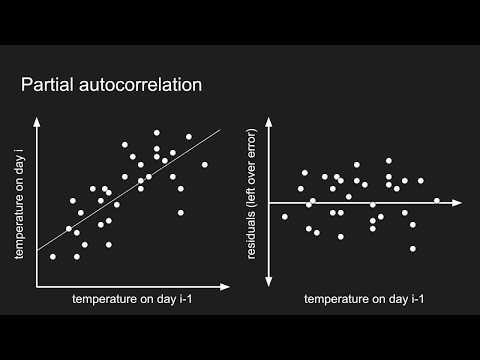

In [22]:
# stream the youtube video
YouTubeVideo('ZjaBn93YPWo', width=720)

Then plot autocorrelation and partial-autocorrelation to see how a frame is correlated to previous frames.

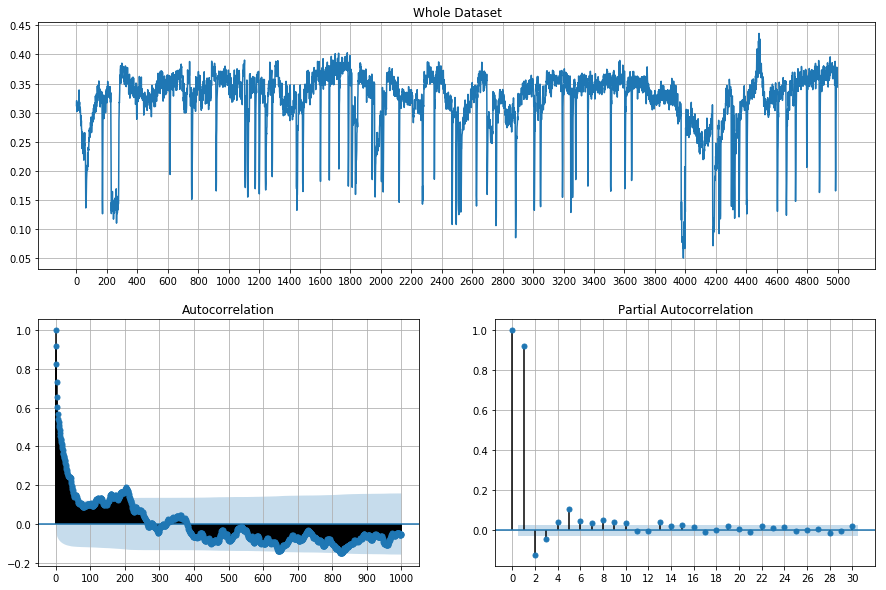

In [23]:
# plot autocorrelation and partial-autocorrelation of WHOLE DATASET
plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2) 
ax0 = plt.subplot(gs[0,:])
ax0.set_title('Whole Dataset')
plt.xticks(np.arange(0, len(data)+1,200))
plt.plot(data)
plt.grid()
ax1 = plt.subplot(gs[1,0])
plt.xticks(np.arange(0, 1000+1,100))
plot_acf(data, lags=1000, ax=ax1)
plt.grid()
ax2 = plt.subplot(gs[1,1])
plt.xticks(np.arange(0, 30+1,2))
plot_pacf(data, lags=30, ax=ax2)
plt.grid();

If we analyze ACF of whole data, we can infer that this is a non-statinary time series but initial phase takes too long to decrease until 65 (during this part plot behaves like stationary data), then increase again until 200 and drops quickly (this part behaves like non-stationary). It's somehow correlated with first two blinks.

> Reminder:  
> blink1 -> (56,87)  
> blink2 -> (165,178)

And for PACF plot numbers of 4, 7, 10, 15, 19 are significant.

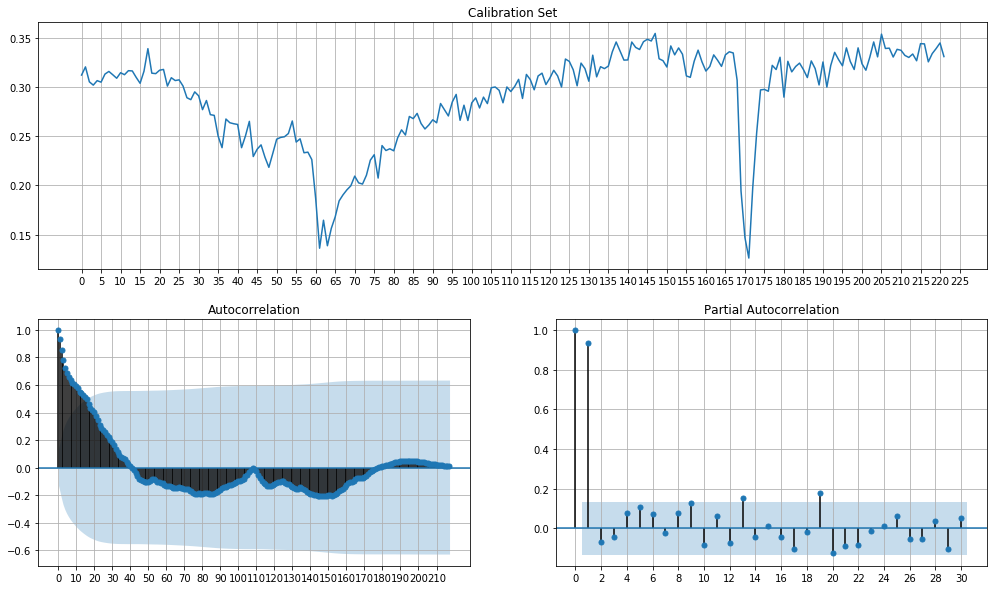

In [24]:
# plot autocorrelation and partial-autocorrelation of CALIBRATION SET
plt.figure(figsize=(17, 10))
gs = gridspec.GridSpec(2, 2) 
ax0 = plt.subplot(gs[0,:])
ax0.set_title('Calibration Set')
plt.xticks(np.arange(0, len(calibration)+5,5))
plt.grid()
plt.plot(calibration)
ax1 = plt.subplot(gs[1,0])
plt.grid()
plt.xticks(np.arange(0, 217+1,10))
plot_acf(calibration, lags=217, ax=ax1)
ax2 = plt.subplot(gs[1,1])
plt.grid()
plt.xticks(np.arange(0, 30+1,2))
plot_pacf(calibration, lags=30, ax=ax2);

When we focus on ACF of calibration set (first 217 frames), we can easily say all plot is non-stationary. In case of effects of blinks, it's hard to say anything on significant manner but after finishing of blink1 (56-87), we see that trend of increasing correlation of lags starts to decrease again. This may be the effect of blink1. After effects of blink1 disappears, graph again starts to become correlated with previous points. And when blink2 (165-178) occurs all of balance in correlation dissappears and converges to zero.

For PACF 5, 21 and 29 are significant numbers. Since we just two blinks in calibration phase we may think about this number somehow relevant to two blinks.

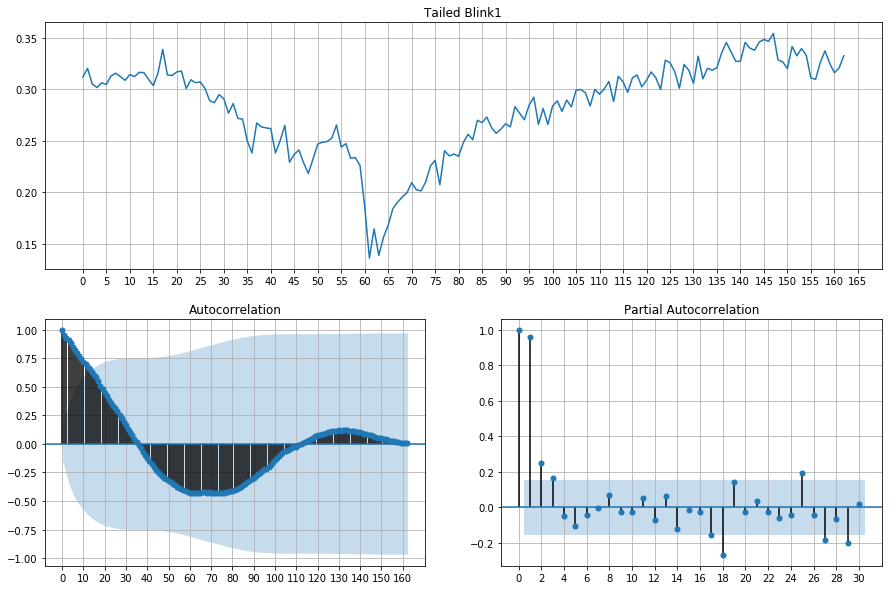

In [25]:
# plot autocorrelation and partial-autocorrelation of BLINK1
plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2) 
ax0 = plt.subplot(gs[0,:])
ax0.set_title('Tailed Blink1')
plt.xticks(np.arange(0, len(blink1)+3,5))
plt.grid()
plt.plot(blink1)
ax1 = plt.subplot(gs[1,0])
plt.grid()
plt.xticks(np.arange(0, 163+1,10))
plot_acf(blink1, lags=len(blink1)-1, ax=ax1)
ax2 = plt.subplot(gs[1,1])
plt.grid()
plt.xticks(np.arange(0, 30+1,2))
plot_pacf(blink1, lags=30, ax=ax2);

This set (0-163) is tailed version of blink1 (56-87) and behaves like a non-stationary data as expected.

For PACF significant numbers are 4, 18, 22, 26. 

Generally a basic EAR value series, follows a linear regression trend (m~0, let's call this **open-eye line**) but with a sudden major drops when blink occurs. Points on **open-eye line** highly correlated to each other. But not to the points on blinks. Even though there's a inner correlation between points on blink points, their correlation decreases when the lag reaches start and end points of blinks. So, we can say that significant number on PACF is relevant to duration of blinks, especially first significant number=4 for this case.

But there's also a nuance for blink points. We say that they are correlated to each other, actually this is only true for seperate halves. After reaching bottom point of blink, there's also decrease in correlation, so number=4 may be relevant to duration/2, not the whole duration.

We can check this by looking at blink1 and blink2.
* if we more focus on (56-76) and try to capture blink1 action more precisely, b duration = 76-56 = 20, it's somewhere between first significant number 4*2=8 and other significant numbers = 18, 22, 26


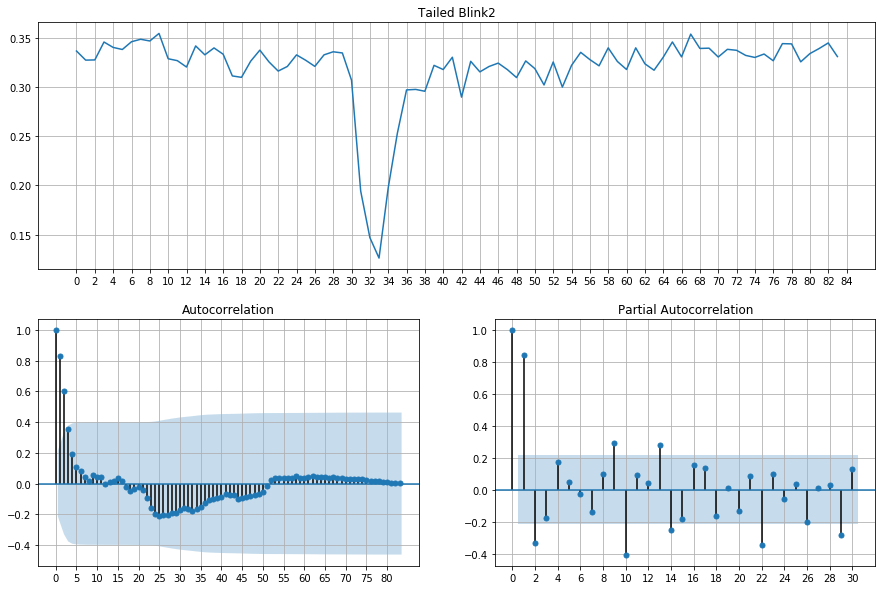

In [26]:
# plot autocorrelation and partial-autocorrelation of BLINK2
plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2) 
ax0 = plt.subplot(gs[0,:])
ax0.set_title('Tailed Blink2')
plt.xticks(np.arange(0, len(blink2)+1,2))
plt.grid()
plt.plot(blink2)
ax1 = plt.subplot(gs[1,0])
plt.grid()
plt.xticks(np.arange(0, 80+1,5))
plot_acf(blink2, lags=len(blink2)-1, ax=ax1)
ax2 = plt.subplot(gs[1,1])
plt.grid()
plt.xticks(np.arange(0, 30+1,2))
plot_pacf(blink2, lags=30, ax=ax2);

The same analysis above,

* major drop for blink2=(30-37) and duration = 37-30 = 7. 
* significant numbers on PACF are 2, 17 and others.

We can conclude that duration of blink2 somewhere between first significant number*2 and second significant number, just like the blink1.

So this way, we may use first significant number as adaptive threshold of EAR_CONSEC_FRAMES.

**NOTE TO MYSELF**

Further research: 
* Improve estimate_first_n() function. Research the possibility of using CasualImpact (https://github.com/dafiti/causalimpact) for adaptive SKIP_FIRST_FRAME
* ARIMA and correlation analysis for detecting real blinks (not other facial expressions like yawning and smiling)
* Finish the pipeline that uses a proper anomaly detection method for the case of adaptive EAR_THRESHOLD
* Implement a function to find significant numbers in PACF to use for adaptive EAR_CONSEC_FRAMES
* Make Normalizaton across videos of subject by using calibration phase. Research non-Gaussian techniques like box-cox transformation


# More Experiments on SKIP_FIRST_FRAMES 

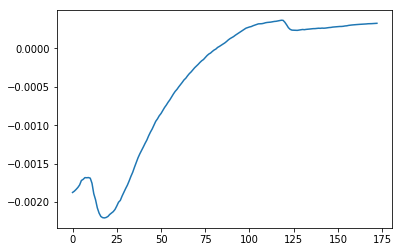

In [27]:
# plot array of slopes
plt.plot(M)

Array of slopes doesn't correlate with blinks so it doesn't tell much.

We can try EWMA also. see: https://medium.com/fintechexplained/understanding-auto-regressive-model-arima-4bd463b7a1bb

**Exponentially Weighted Moving Average** is a recursive way to calculate mean.

$$ EWMA(t) = (1 - alpha) * EWMA(t - 1) + alpha * CurrentValue $$

and $1/alpha$ gives number of past values to be considered.

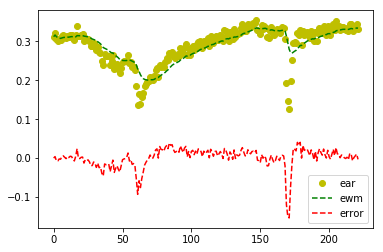

In [28]:
# calculate EWM with low weight on current values (alpha) so span is 10
cal_df = pd.Series(calibration)
cal_ewm = cal_df.ewm(alpha=0.1).mean()

#calculate mean_squared_error
cal_err = cal_df - cal_ewm

# plot EWM
plt.plot(np.arange(n),calibration,'yo', cal_ewm, '--g', cal_err, '--r')
plt.legend(labels = ['ear','ewm','error']);


so it can be usefull to differentiate fake blinks to others. let's try it on whole data.

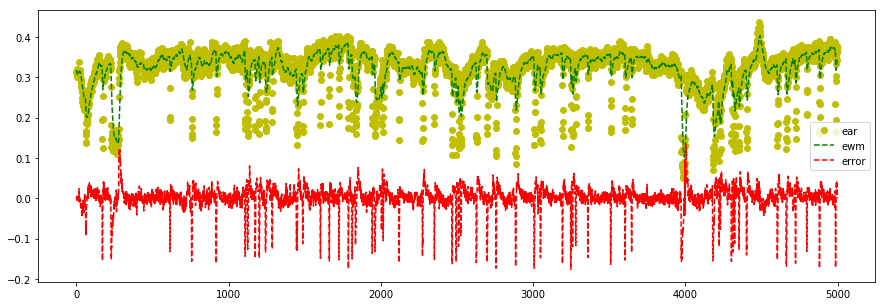

In [29]:
# try EWMA on whole video
# calculate EWM with low weight on current values (alpha) so span is 10
d_df = pd.Series(data)
d_ewm = d_df.ewm(alpha=0.1).mean()

#calculate mean_squared_error
d_err = d_df- d_ewm

# plot EWM
plt.figure(figsize=(15,5))
plt.plot(np.arange(5000),data,'yo', d_ewm, '--g', d_err, '--r')
plt.legend(labels = ['ear','ewm','error']);

so let's analyze if we can catch some blink with outlier analysis.

In [30]:
# run detect_outliers_iqr() on errors
_, d_outliers, d_upper, d_lower =  detect_outliers_iqr(d_err, alpha=4)

#only get negatif outliers
d_outliers = [(a,b) for (a,b) in d_outliers if b<0]
d_outlier_indexes = list(zip(*d_outliers))[0]
d_outlier_values = list(zip(*d_outliers))[1]

Percentiles: 25th=-0.007, 75th=0.015, IQR=0.021
Identified outliers: 197
Non-outlier observations: 4803



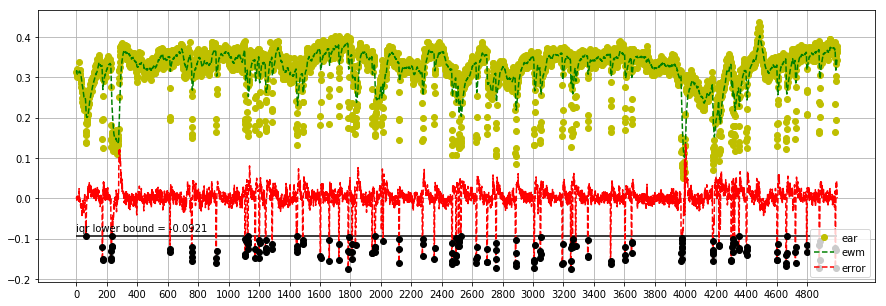

In [31]:
# plot calibration and errors
plt.figure(figsize=(15,5))
plt.xticks(np.arange(0, 5000, 200))
plt.grid()
plt.plot(data,'yo', d_ewm, '--g', d_err, '--r')
plt.legend(labels = ['ear','ewm','error'], loc='lower right')

# plot outliers for errors
plt.plot(d_outlier_indexes, d_outlier_values, 'ko')
plt.hlines(d_lower, 0, 5000, colors='k', linestyles='-')
plt.text(0, d_lower + 0.01, 'iqr lower bound = {:.4f}'.format(d_lower), color='k');

examine frames between 1900-2200 if it's a real blink or not.

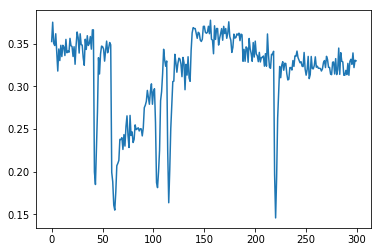

In [32]:
plt.plot(data[1900:2200]);

1th blink started at: 1940th frame, middle of action at: 1945th frame, ended at: 1950th frame


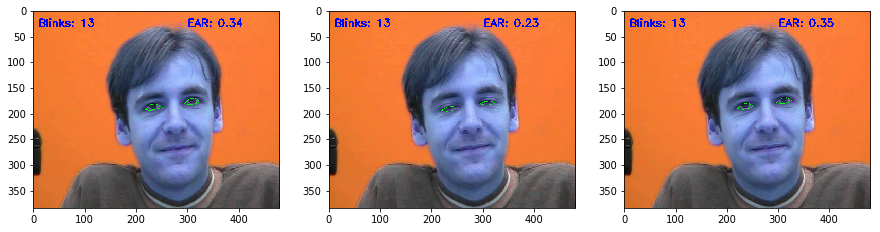

2th blink started at: 1950th frame, middle of action at: 1965th frame, ended at: 1980th frame


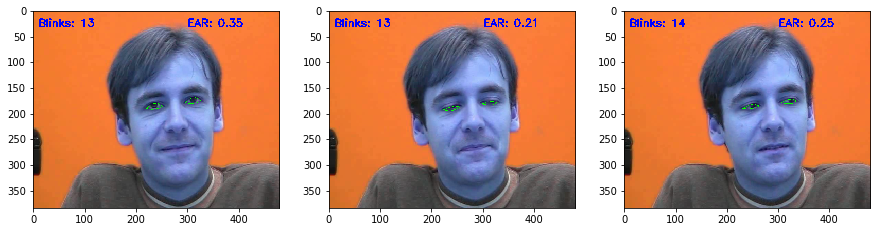

3th blink started at: 2000th frame, middle of action at: 2015th frame, ended at: 2030th frame


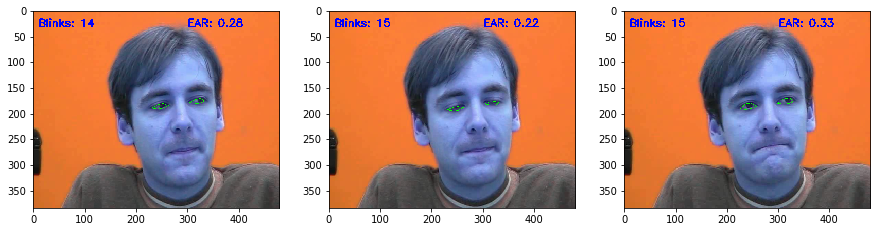

4th blink started at: 2110th frame, middle of action at: 2120th frame, ended at: 2130th frame


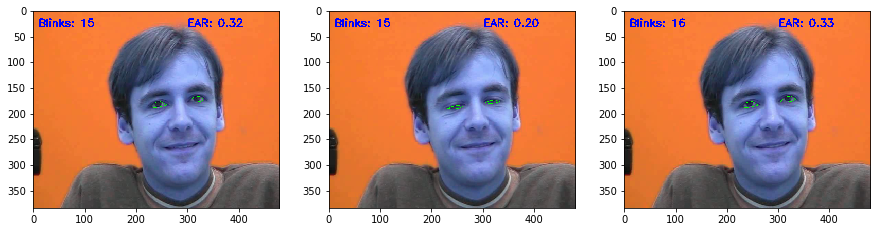

In [33]:
# take starting point as 1900 and show some blinks
X=1900
display_blinks([(X+40,X+50),(X+50,X+80),(X+100,X+130),(X+210,X+230)], fr)

Apparently it's not a real blink, if we compare it to a real blink like (2110:2120)(4th row of pictures above), we can see that it's just a looking down. So taking alpha=4 for detect_outliers_iqr() function would be good choice, but we need to find a way to make it adaptive either. (Maybe when we do normalization for ears, it would be adaptive)

another way is using std for detecting outliers. so that;

Identified outliers: 186
Non-outlier observations: 4814



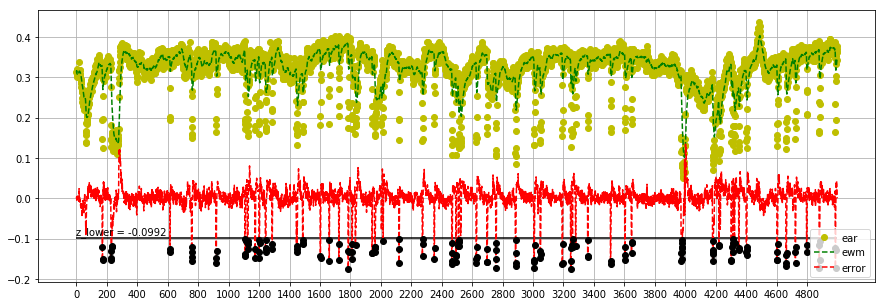

In [34]:
# run detect_outliers_z() on errors
_, d_outliers_z, d_upper_z, d_lower_z =  detect_outliers_z(d_err,3)

#only get negatif outliers
d_outliers_z = [(a,b) for (a,b) in d_outliers_z if b<0]
d_outlier_indexes_z = list(zip(*d_outliers_z))[0]
d_outlier_values_z = list(zip(*d_outliers_z))[1]

# plot calibration and errors
plt.figure(figsize=(15,5))
plt.xticks(np.arange(0, 5000, 200))
plt.grid()
plt.plot(data,'yo', d_ewm, '--g', d_err, '--r')
plt.legend(labels = ['ear','ewm','error'], loc='lower right')

# plot outliers for errors
plt.plot(d_outlier_indexes_z, d_outlier_values_z, 'ko')
plt.hlines(d_lower_z, 0, 5000, colors='k', linestyles='-')
plt.text(0, d_lower_z + 0.01, 'z_lower = {:.4f}'.format(d_lower_z), color='k');

care for blink around 60 and 2000, they have to be excluded. so z_limit = 3 seems ok.

Consequently, we can use EWMA and outlier detection to update estimate_first_n() function to get at least 1 blink. Remember this function can wait a blink to complete its action, but doesn't guarantee to catch one.

For later purposes we can also try this method as general blink detector and compare to SVM model.

In [35]:
# calculate EWMA, error and then outliers to detect blinks
def detect_closeness_ewma(data_df):
    # calculate EWMA with low weight on current values (alpha) so span is 10
    data_ewm = data_df.ewm(alpha=0.1).mean()

    # calculate mean_squared_error
    data_err = data_df - data_ewm
    
    # run detect_outliers_iqr() on errors
    _, outliers, _, _ =  detect_outliers_z(data_err,3)

    # only get negative outliers
    outliers_neg = [(a,b) for (a,b) in outliers if b<0]
    outlier_indexes = list(zip(*outliers_neg))[0]
    outlier_values = list(zip(*outliers_neg))[1]
    
    return outlier_indexes, outlier_values

In [36]:
# get first blink
# returns last frame of the blink detected
def construct_blinks_ewma(data_df):
    # get outliers
    closed_indexes, _ = detect_closeness_ewma(data_df)
    
    # detect consecutive closed frames
    gaps = [(s, e) for s, e in zip(closed_indexes, closed_indexes[1:]) if s+1 < e] # find gaps between groups
    borders = iter([closed_indexes[0]] + list(sum(gaps, () )) + [closed_indexes[-1]]) # use sum() as a trick to flatten gaps, then append first and last frames 
    groups = list(zip(borders, borders)) # zip again to build group again
    groups_verbose = [tuple(range(s, e + 1)) for (s,e) in groups] # write elements of groups verbosely
    
    # correct gaps and construct verbosely
    gaps_verbose = [tuple(range(s+1,e)) for (s, e) in gaps]
    
    return groups_verbose, gaps_verbose, closed_indexes

In [37]:
# updated version of estimate_first_n by EWMA
# estimate SKIP_FIRST_FRAMES threshold
# returns n -> estimated value of the threshold
# m0 -> slope at this point
# array of slopes until this point
def estimate_first_n_v2(data_df, start_n=40, limit_n=300, step=1, epsilon=10e-8):
    # run get_first_blink(data) to get blink_guarenteed
    blinks, _, _ = construct_blinks_ewma(data_df)               
    first_blink = blinks[0]
    ending_frame = first_blink[-1]
    
    n = start_n 
    M=[]
    while True:
        # for first n values fit a linear regression line 
        data0 = data_df[:n]
        m0,b0 = np.polyfit(np.arange(n),data0, 1)
        M.append(m0)
        
        # check if n + step reaches limit
        if n + step > limit_n-1:
            print("error - reached the limit")
            break

        # for first n + step values fit a linear regression line 
        data1 = data[:n+step]
        m1,b1 = np.polyfit(np.arange(n + step),data1, 1)

        # if m1-m0 converges to epsilon
        if abs(m1 - m0) < epsilon and m0 > 0 and n > ending_frame:
            break
        n += step
    
    return n, m0, M

In [38]:
# run the function above
data_df = pd.Series(data)
first_n, _, _ = estimate_first_n_v2(data_df, limit_n=limit_frame)
calibration = data[:first_n]
first_n

Identified outliers: 186
Non-outlier observations: 4814



222

So we guarenteed at least one blink, waited it to finish it's action and that' way we got enough information for calibration. Also we overcome the issue of fake blinks for at least calibration phase.

We can say that we found an adaptive way for SKIP_FIRST_FRAMES by using **"EWMA + errors + outlier detection"** pipeline. 

**NOT:** adaptive z_limit for outlier detection still requires to be examined. We will do it after normalizaton process. Along with using the pipeline above on EAR_TRESHOLD.

**one extra experiment with RSI (Relative strength indicator):**

$$ RSI = 1 - 100 / (1 + RS) $$

$$ RS = Avg Gain / Avg Loss $$

see http://www.andrewshamlet.net/2017/06/10/python-tutorial-rsi/

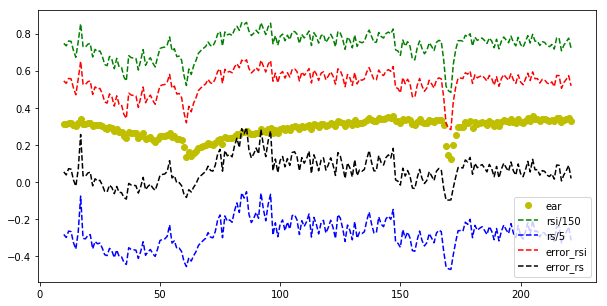

In [39]:
def rsi_rs(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs), rs

cal_df = pd.Series(calibration)
rsi, rs = rsi_rs(cal_df, 10)

err_rsi = rsi - calibration[10:]
err_rs = rs- calibration[10:]

# plot EWM
plt.figure(figsize=(10,5))
plt.plot(np.arange(10,n),calibration[10:],'yo', rsi/150+0.4, '--g', rs/5-0.5, '--b', err_rsi/150+0.2, '--r', err_rs/5-0.1, '--k')
plt.legend(labels = ['ear','rsi/150','rs/5', 'error_rsi', 'error_rs'], loc='lower right');

So unlike simple EWMA, RSI/RS doesn't produce good results when we try to distinct first and second blink, so we will move on with EWMA.

# More experiments on EAR_CONSEC_FRAMES

---> find a way to get significant values on PACF and ACF.  
read: **1.** https://medium.com/fintechexplained/forecasting-time-series-explained-5cc773b232b6  
**2.** https://medium.com/fintechexplained/understanding-auto-regressive-model-arima-4bd463b7a1bb  
**3.** https://towardsdatascience.com/forecasting-exchange-rates-using-arima-in-python-f032f313fc56  
**4.** https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/autocorrelation/interpret-the-results/autocorrelation-function-acf/  
**5.** https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/  


let's start with stationarity analysis.

In [40]:
# print statistics of rolling mean/std and dickey-fuller test
def get_stationarity(timeseries_df):
    
    # rolling statistics
    rolling_mean = timeseries_df.rolling(window=12).mean()
    rolling_std = timeseries_df.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries_df, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries_df)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    return result[0], result[1], result[4]['1%'], result[4]['5%'], result[4]['10%']

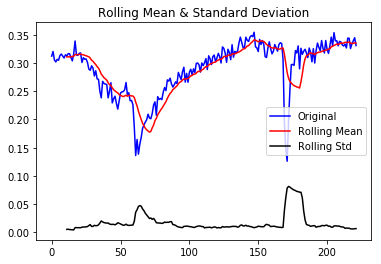

ADF Statistic: -2.7179812397087564
p-value: 0.07097807907524308
Critical Values:
	1%: -3.4602906385073884
	5%: -2.874708679520702
	10%: -2.573788599127782


In [41]:
# run the function above
get_stationarity(cal_df);

adf should be lower than the critical values and p_value must below the limit 0.05.  
see: https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

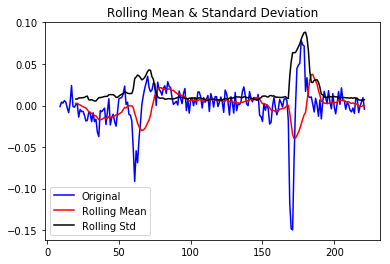

ADF Statistic: -6.40934606101199
p-value: 1.9079171390691545e-08
Critical Values:
	1%: -3.461878735881654
	5%: -2.875403665910809
	10%: -2.574159410430839


In [42]:
# run the function for error
rolling_mean = cal_df.rolling(window=10).mean()
cal_df_minus_mean = cal_df - rolling_mean
cal_df_minus_mean.dropna(inplace=True)
get_stationarity(cal_df_minus_mean);

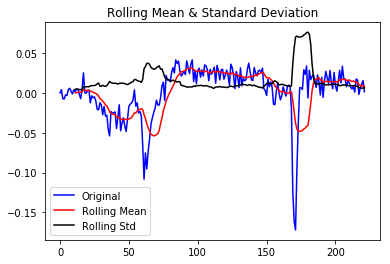

ADF Statistic: -4.080664920945092
p-value: 0.0010423048812229444
Critical Values:
	1%: -3.4602906385073884
	5%: -2.874708679520702
	10%: -2.573788599127782


In [43]:
# exponentially decaying ewm
rolling_mean_exp_decay = cal_df.ewm(halflife=12, min_periods=0, adjust=True).mean()
cal_df_exp_decay = cal_df - rolling_mean_exp_decay
cal_df_exp_decay.dropna(inplace=True)
get_stationarity(cal_df_exp_decay);

So error performed better. It's more stationary than original and exponential decay. We can try one more trick which is time shifting.

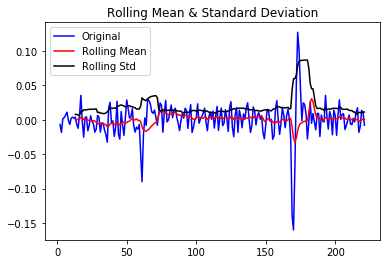

ADF Statistic: -7.5140703245621205
p-value: 3.945536099775789e-11
Critical Values:
	1%: -3.4612821203214907
	5%: -2.875142613826617
	10%: -2.574020122281422


In [44]:
# time shifting by 2
cal_df_shift = cal_df - cal_df.shift(2)
cal_df_shift.dropna(inplace=True)
get_stationarity(cal_df_shift);

**We can build conplete ARIMA model also:**  
Three integers (p, d, q) are typically used to parametrize ARIMA models.  
p: number of autoregressive terms (AR order)  
d: number of nonseasonal differences (differencing order)  
q: number of moving-average terms (MA order)  

PACF determines AR order.  
ACF determines MA order.

see: https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

Plot PACF and ACF of cal_df:

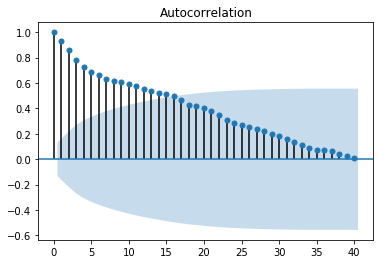

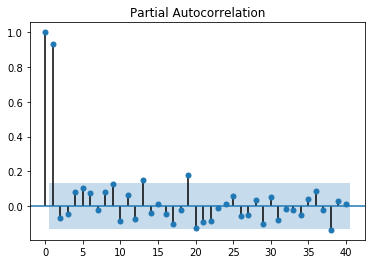

In [45]:
plot_acf(cal_df, lags=40)
plot_pacf(cal_df, lags=40);

calculate acf and pacf values:

In [46]:
# acf
acf_vals, conf_acf, qstat, pvals = acf(cal_df_minus_mean,  alpha=.05, qstat=True, nlags=25)

# pacf
pacf_vals, conf_pacf = pacf(cal_df_minus_mean,  alpha=.05, nlags=25)
conf_pacf

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


array([[ 1.        ,  1.        ],
       [ 0.64852966,  0.91711869],
       [-0.32401001, -0.05542097],
       [-0.31947682, -0.05088778],
       [-0.20929364,  0.0592954 ],
       [-0.1771111 ,  0.09147794],
       [-0.16903019,  0.09955885],
       [-0.24562905,  0.02295999],
       [-0.12487986,  0.14370918],
       [-0.01296109,  0.25562795],
       [-0.20256452,  0.06602452],
       [-0.1250786 ,  0.14351044],
       [-0.23875759,  0.02983145],
       [ 0.00837936,  0.2769684 ],
       [-0.1486526 ,  0.11993644],
       [-0.10426135,  0.16432769],
       [-0.16400538,  0.10458366],
       [-0.18525962,  0.08332942],
       [-0.14598174,  0.1226073 ],
       [ 0.07369094,  0.34227998],
       [-0.21412399,  0.05446504],
       [-0.20398832,  0.06460072],
       [-0.18737922,  0.08120982],
       [-0.13267668,  0.13591236],
       [-0.11165062,  0.15693842],
       [-0.03287042,  0.23571862]])

**We can find significant values of acf and pacf by using confidence interval values:**

In [47]:
# function runs acf and pacf then finds significant values
def find_significant_vals(timeseries, nlags=40, is_first=True):
    # calculate acf and pacf values
    _, conf_acf = acf(timeseries,  alpha=.05, nlags=nlags)
    _, conf_pacf = pacf(timeseries,  alpha=.05, nlags=nlags)
    
    # initilize output values
    sig_acf = 0
    sig_pacf = 0
    
    # for acf
    for i in range(nlags):
        if conf_acf[i][0]>0:
            sig_acf = i
        elif conf_acf[i][1]<0:
            sig_acf = i
        else:
            break
    
    # for pacf
    for i in range(nlags):
        if conf_pacf[i][0]>0:
            sig_pacf = i
        elif conf_pacf[i][1]<0:
            sig_pacf = i
        else:
            break
    
    # if significant numbers are less than 3 (1th is already 0 lag so it doesn't count)
    # try to detect one more sequence of significant values
    privelege = 0
    end = 0
    if sig_acf<3:
        # for acf
        for i in range(nlags):
            if conf_acf[i][0]>0:
                sig_acf = i
                if privelege > 0:
                    end=1
            elif conf_acf[i][1]<0:
                sig_acf = i
                if privelege > 0:
                    end=1
            else:
                if end == 1:
                    break
                privelege += 1
                continue
                
    privelege = 0
    end = 0            
    if sig_pacf<3:
        # for pacf
        for i in range(nlags):
            if conf_pacf[i][0]>0:
                sig_pacf = i
                if privelege > 0:
                    end=1
            elif conf_pacf[i][1]<0:
                sig_pacf = i
                if privelege > 0:
                    end=1
            else:
                if end == 1:
                    break
                privelege += 1
                continue
    
    # if significant numbers are more than 9 use error of moving average to approximate
    if sig_pacf>9 or sig_acf>9:
        rolling_mean = timeseries.rolling(window=10).mean()
        cal_df_minus_mean = timeseries - rolling_mean
        cal_df_minus_mean.dropna(inplace=True)
        if is_first == True:
            sig_pacf, sig_acf = find_significant_vals(cal_df_minus_mean, nlags, False)
    return  sig_pacf, sig_acf

In [48]:
# run the function above
p, q = find_significant_vals(cal_df, nlags=40)
p, q

(3, 3)

since significant acf values of cal_df are way more than 10, our function use approximation (error to ma). let's see if it fits well to original series.

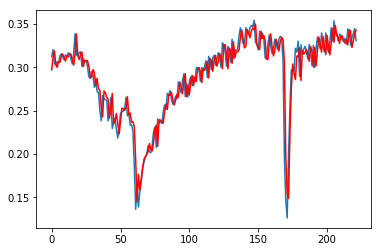

In [49]:
# fit ARIMA model and plot it 
model = ARIMA(cal_df, order=(3,0,3))
results = model.fit(disp=0)
plt.plot(cal_df)
plt.plot(results.fittedvalues, color='red');

so it fits nicely. It could have been better but it needs more computation time to use values (p,d,q) more than 10.

**we can try grid search to find best parameters:**  
see: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

In [50]:
# evaluate combinations of p, d and q values for an ARIMA model
def gridsearch_ARIMA_params(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    model = ARIMA(dataset, order=order)
                    results = model.fit(disp=0)
                    mse = mean_squared_error(dataset[d:], results.fittedvalues)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.8f' % (order,mse))
                except:
                    print('ARIMA{} exception'.format(order))
                    continue
    print('Best ARIMA%s MSE=%.8f' % (best_cfg, best_score))
    return best_cfg, best_score

In [51]:
# run the function above
warnings.filterwarnings("ignore")
order, score = gridsearch_ARIMA_params(cal_df, range(0,10), range(0,1), range(0,4))

ARIMA(0, 0, 0) MSE=0.00222790
ARIMA(0, 0, 1) MSE=0.00088980
ARIMA(0, 0, 2) MSE=0.00055398
ARIMA(0, 0, 3) MSE=0.00041911
ARIMA(1, 0, 0) MSE=0.00029188
ARIMA(1, 0, 1) MSE=0.00029121
ARIMA(1, 0, 2) MSE=0.00029011
ARIMA(1, 0, 3) MSE=0.00028953
ARIMA(2, 0, 0) MSE=0.00029114
ARIMA(2, 0, 1) MSE=0.00029102
ARIMA(2, 0, 2) MSE=0.00028996
ARIMA(2, 0, 3) MSE=0.00028420
ARIMA(3, 0, 0) MSE=0.00029055
ARIMA(3, 0, 1) MSE=0.00029012
ARIMA(3, 0, 2) MSE=0.00028112
ARIMA(3, 0, 3) MSE=0.00028264
ARIMA(4, 0, 0) MSE=0.00028890
ARIMA(4, 0, 1) MSE=0.00028308
ARIMA(4, 0, 2) MSE=0.00028113
ARIMA(4, 0, 3) MSE=0.00027784
ARIMA(5, 0, 0) MSE=0.00028581
ARIMA(5, 0, 1) MSE=0.00028266
ARIMA(5, 0, 2) MSE=0.00028266
ARIMA(5, 0, 3) MSE=0.00027868
ARIMA(6, 0, 0) MSE=0.00028366
ARIMA(6, 0, 1) MSE=0.00028352
ARIMA(6, 0, 2) MSE=0.00027982
ARIMA(6, 0, 3) MSE=0.00027688
ARIMA(7, 0, 0) MSE=0.00028359
ARIMA(7, 0, 1) MSE=0.00028351
ARIMA(7, 0, 2) MSE=0.00027396
ARIMA(7, 0, 3) MSE=0.00027587
ARIMA(8, 0, 0) MSE=0.00028239
ARIMA(8, 0

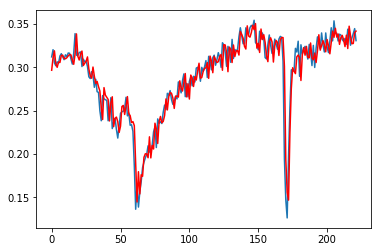

In [52]:
# fit ARIMA model and plot it 
model = ARIMA(cal_df, order=(9,0,2))
results = model.fit(disp=0)
plt.plot(cal_df)
plt.plot(results.fittedvalues, color='red');

* our aproximate function find_significant_vals() tooks sec and it's (3,0,3) MSE is 0.00028264  
* gridsearch_ARIMA_params() finds optimum parameters (9,0,2) but it tooks so much time and it's MSE is not so different 0.00026935

Hence, we can use aproximate function find_significant_vals() to find significant values of PACF and ACF.

# Some experiments with CasualImpact

* https://github.com/dafiti/causalimpact

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.31               16.86
Prediction (s.d.)         0.3 (0.01)         16.06 (0.4)
95% CI                    [0.28, 0.31]       [15.27, 16.85]

Absolute effect (s.d.)    0.01 (0.01)        0.8 (0.4)
95% CI                    [0.0, 0.03]        [0.02, 1.59]

Relative effect (s.d.)    4.98% (2.5%)       4.98% (2.5%)
95% CI                    [0.09%, 9.9%]      [0.09%, 9.9%]

Posterior tail-area probability p: 0.02
Posterior prob. of a causal effect: 97.7%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.31. By contrast, in the absence of an
intervention, we would have expected an average response of 0.3.
The 95% interval of this counterfactual prediction is [0.28, 0.31].
Subtracting this prediction from the observed response yields

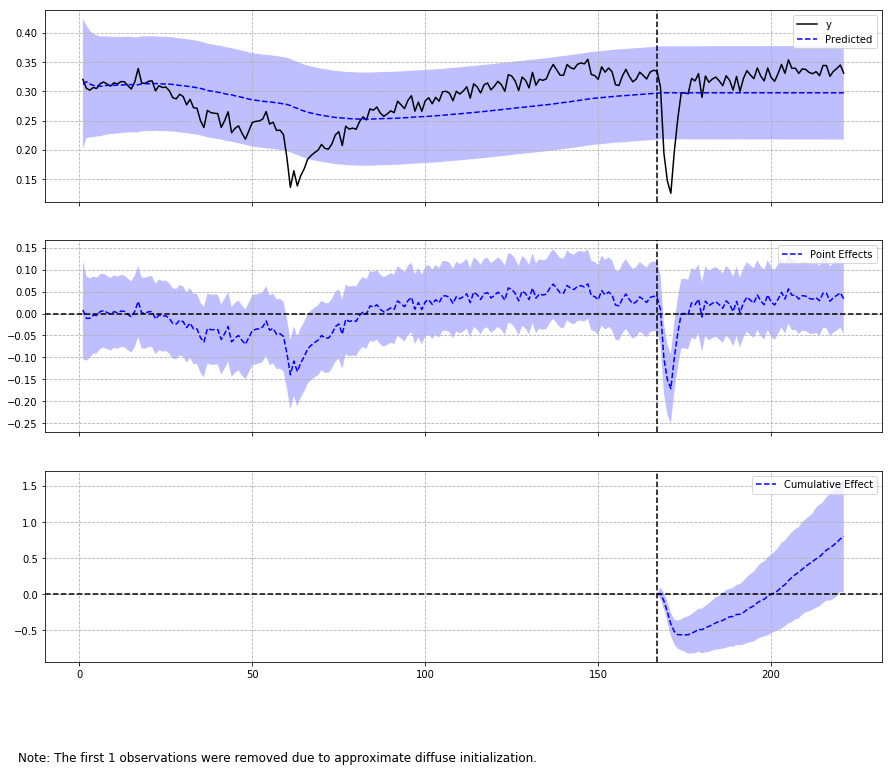

In [53]:
# after first blink how data changed
first_frame = 167
pre_period = [0, first_frame]
post_period = [first_frame+1, len(calibration)-1]
ci = CausalImpact(calibration, pre_period, post_period)
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()

So it's resembles our ewm error function and can be used for seeing the reaction (impact) of predefined external action. Using for detecting impacts is possible but it would be an overkill.

# Building Adaptive Model

We used a post-process function recalculate_data_ewma() to correct outputs of process_video() but it requires to redefine it for real-time use cases. Especially we need to use a variable current_ewma for all of the frames. We will do it in later steps of the project.

First define the recalculate_data_ewma() function:

In [54]:
# recalculate outputs of process_video()
def recalculate_data_ewma(frame_info_df, closeness_list, blink_list, consec_th):
    # reconstruct blinks using EWMA method
    data_df = frame_info_df['avg_ear']
    blinks, gaps, closed_indexes = construct_blinks_ewma(data_df) 
    
    # rebuild closeness_list
    length = len(frame_info_df)
    closeness_list = [0] * length
    for i in closed_indexes:
        closeness_list[i] = 1

    # update frame_info_df['closeness']
    new_column_closeness = pd.Series(closeness_list, name='closeness')
    frame_info_df.update(new_column_closeness)
    
    # update frame_info_df['blink_no']
    for blink in blinks:
        if len(blink) < consec_th:
            blinks.remove(blink)
            
    blink_start_frame_list = [0] * len(data)
    blink_end_frame_list = [0] * len(data)
    blink_no_list = [0] * len(data)
    for i, blink in enumerate(blinks):
        for frame in blink:
            blink_no_list[frame-1] = i
        blink_no_list[frame:] = [i+1]*len(blink_no_list[frame:])
        blink_start_frame_list[frame:] = [blink[0]]*len(blink_start_frame_list[frame:])
        blink_end_frame_list[frame:] = [blink[-1]]*len(blink_end_frame_list[frame:])

        
    new_column_blink_no = pd.Series(blink_no_list, name='blink_no')
    frame_info_df.update(new_column_blink_no)
    
    # update frame_info_df['blink_start_frame']
    new_column_blink_start_frame = pd.Series(blink_start_frame_list, name='blink_start_frame')
    frame_info_df.update(new_column_blink_start_frame)
    
    # update frame_info_df['blink_end_frame']
    new_column_blink_end_frame = pd.Series(blink_end_frame_list, name='blink_end_frame')
    frame_info_df.update(new_column_blink_end_frame)
    
    return frame_info_df, closeness_list, blink_list
    

Let's define the adaptive_model function:

In [55]:
# build adaptive_model pipeline
# if you want to display blinks set display_blinks=True (it requires long time and memory so default is False)
# if you want to read annotation file and run comparison metrics set test_extention="tag" or any file extension
# REMARK: your annotation file an video file must have the same name to use this function.
# if you want to write outputs set write_results=True
# You change maximum duration of calibration phase in secs by calibration_max argument. Default is 10 secs
def adaptive_model(input_full_path, display_blinks=False, test_extention=False, write_results=False, \
                   calibration_max=10):
    
    # calculate a limit_n for "calibration_max" secs with using fps of the video
    limit_frame = secs_to_frame_count(input_full_path, calibration_max)
    
    # process the video and get the ear values for the first "limit_frame" values
    df_init, _, _, _, _, _ = process_video(input_full_path, up_to=limit_frame)
    
    # build series
    data_init = df_init['avg_ear']
        
    # estimate skip_n and build calibration dataframe
    skip_n, _, _ = estimate_first_n_v2(data_init, limit_n=limit_frame)
    calibration = data_init[:skip_n]
    cal_df = pd.DataFrame(calibration)
    
    # estimate consec_th using calibration dataframe
    consec_th, _ = find_significant_vals(cal_df, nlags=40)
    
    # after the estimation of 3 thresholds, process the video wholly and get the full results
    frame_info_df, closeness_predictions, blink_predictions, frames, video_info, scores_string \
        = process_video(input_full_path)
    
    # recalculate outputs by using three thresholds
    frame_info_df, closeness_predictions, blink_predictions = recalculate_data_ewma(frame_info_df, \
                                                            closeness_predictions,blink_predictions, consec_th)
              
    # recalculate data again by skipping "skip_n" frames
    frame_info_df, closeness_predictions_skipped, blink_predictions_skipped, frames_skipped \
        = skip_first_n_frames(frame_info_df, closeness_predictions, blink_predictions, frames, \
                              skip_n = skip_n)

    # first display statistics by using original outputs
    scores_string += display_stats(closeness_predictions, blink_predictions, video_info)

    # then display statistics by using outputs of skip_first_n_frames() function which are 
    #"closeness_predictions_skipped" and "blinks_predictions_skipped"
    if(skip_n > 0):
        scores_string += display_stats(closeness_predictions_skipped, blink_predictions_skipped, video_info, \
                                 skip_n = skip_n)
    
    # if you want to display blinks
    if display_blinks == True:
        # display starting, middle and ending frames of all blinks by using "blinks" and "frames"
        display_blinks(blink_predictions_skipped, frames_skipped)
        
    # if you want to read tag file
    if test_extention != False:
        extention = ""
        # default file extension is ".tag"
        if test_extention == True:
            extention = "tag"
        else:
            extention = test_extention
        # remove video extention i.e. ".avi"
        clean_path = os.path.splitext(input_full_path)[0]
        # read tag file
        closeness_test, blinks_test = read_annotations("{}.{}".format(clean_path, extention), skip_n = skip_n)
        # display results by using outputs of read_annotations() function 
        # which are "closeness_test", "blinks_test"
        scores_string += display_stats(closeness_test, blinks_test, skip_n = skip_n, test = True)
        # display results by using "closeness_test" and "closeness_predictions"
        scores_string += display_test_scores(closeness_test, closeness_predictions_skipped)
        
    # if you want to write results
    if write_results == True:
        # write prediction output files by using outputs of skip_first_n_frames() function
        write_outputs(input_full_path, closeness_predictions_skipped, blink_predictions_skipped, \
                      frame_info_df, scores_string)
        if test_extention != False:
            # write test output files by using outputs of skip_first_n_frames() function
            # no need to write frame_info_df and scores_string since they already have written above
            write_outputs(input_full_path, closeness_test, blinks_test, \
                          test = True)
            
    return frame_info_df, closeness_predictions_skipped, blink_predictions_skipped, frames_skipped, \
            video_info, scores_string

In [56]:
# test the function above
fdf, cp, bp, fr, vi, st = adaptive_model("../input/blinkdata/talkingFace/talking.avi", \
                                    test_extention = "tag", write_results = True)

Processing talking.avi has done.


Identified outliers: 10
Non-outlier observations: 290

Processing talking.avi has done.


Identified outliers: 186
Non-outlier observations: 4814

Video info
FPS: 30.0
FRAME_COUNT: 5000
DURATION (s): 166.67

Statistics on the prediction set are
TOTAL NUMBER OF FRAMES PROCESSED: 5000
NUMBER OF CLOSED FRAMES: 173
NUMBER OF BLINKS: 45


Video info
FPS: 30.0
FRAME_COUNT: 5000
DURATION (s): 166.67

After skipping 222 frames,
Statistics on the prediction set are
TOTAL NUMBER OF FRAMES PROCESSED: 4778
NUMBER OF CLOSED FRAMES: 170
NUMBER OF BLINKS: 43


After skipping 222 frames,
Statistics on the test set are
TOTAL NUMBER OF FRAMES PROCESSED: 4778
NUMBER OF CLOSED FRAMES: 151
NUMBER OF BLINKS: 60


EYE CLOSENESS FRAME BY FRAME TEST SCORES

ACCURACY: 0.9759

AUC: 0.8338

CONFUSION MATRIX:
[[4560   67]
 [  48  103]]

FALSE POSITIVES:
48 out of 151 positive labels (0.3179%)

FALSE NEGATIVES:
67 out of 4627 negative labels (0.0145%)

PRECISION, RECALL, F1 scores